<a href="https://colab.research.google.com/github/aman0003/Innovative-Cab-Software/blob/master/NYC_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Data Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
df = pd.read_excel('/content/drive/My Drive/ML/taxi-train.xlsx', nrows = 500000, parse_dates = ['pickup_datetime']).drop(columns = 'key')
print("The dataset is {} taxi rides".format(len(df)))

The dataset is 500000 taxi rides


In [0]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21+00:00,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16+00:00,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42+00:00,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1


In [0]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000,500000.000,500000.000,499995.000,499995.000,500000.000
mean,11.358,-72.520,39.920,-72.522,39.917,1.683
std,9.917,11.857,8.073,11.797,7.391,1.307
min,-44.900,-2986.242,-3116.285,-3383.297,-2559.749,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,500.000,2140.601,1703.093,40.851,404.617,6.000


Problems found - 

1). Min fare amount is negative.

2). Min and Max longitude and latitude look unreal.

3). Min passenger count is 0.

Fixing them - 

1). The initial charge is $2.5, so we are removing fare amount smaller than this amount.

2). New York city longitudes are around -74 and latitudes are around 41.

3). Remove 0 passenger count.

In [0]:
print(f"There are {len(df[df['fare_amount'] < 0])} negative fares.")
print(f"There are {len(df[df['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(df[df['fare_amount'] > 100])} fares greater than $100.")

There are 21 negative fares.
There are 14 $0 fares.
There are 214 fares greater than $100.


In [0]:
# as fare should be more than $2.5 bcoz first charge of the taxi is $2.5.
df = df[df['fare_amount'].between(left = 2.5, right = 100)]

In [0]:
df = df[df['pickup_longitude'] > -78]
df = df[df['pickup_longitude'] < -70]
df = df[df['dropoff_longitude'] > -78]
df = df[df['dropoff_longitude'] < -70]
df = df[df['pickup_latitude'] > 37]
df = df[df['pickup_latitude'] < 45]
df = df[df['dropoff_latitude'] > 37]
df = df[df['dropoff_latitude'] < 45]

For Passenger count - 

In [0]:
df = df[df['passenger_count'] > 0]

In [0]:
# It looks much better now!
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,487716.000,487716.000,487716.000,487716.000,487716.000,487716.000
mean,11.299,-73.975,40.751,-73.974,40.751,1.690
std,9.375,0.044,0.034,0.042,0.037,1.306
min,2.500,-77.902,37.420,-77.817,37.347,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.767,-73.965,40.768,2.000
max,100.000,-70.141,43.183,-70.050,44.600,6.000


In [0]:
# to find null values
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### EDA

Let's try to visualize ten taxi rides.

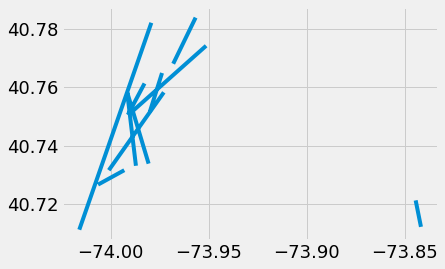

In [0]:
# we're visualizing and calculating trip distance by plotting lat and long of the taxi rides. "NONE" is used to differentiate b/w the co-ordinates of the distance. 
# some trips r very long but some are very small.
import seaborn as sns
def showrides(df, numlines):
  lats = []
  lons = []
  goodrows = df[df['pickup_longitude'] < -70]
  for iter, row in goodrows[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)
  #print(lats, "\n", lons)
  plt.plot(lons, lats)

showrides(df, 10)

Some ride distances are very short, some are pretty long.

### Fare amount

For visualization purposes, I'll create a binned version of the fare. This divides the variable into a number of bins, turning a continuous variable into a discrete, categorical variable.

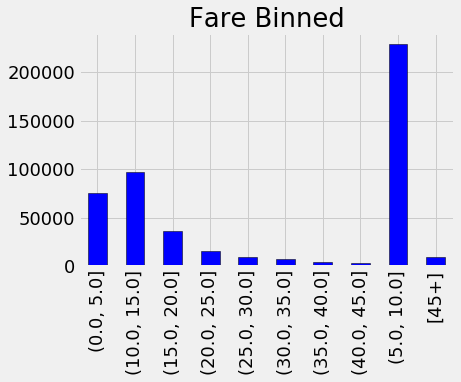

In [0]:
# Bin the fare and convert to string
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
df.loc[df['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
df.loc[df['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
df['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

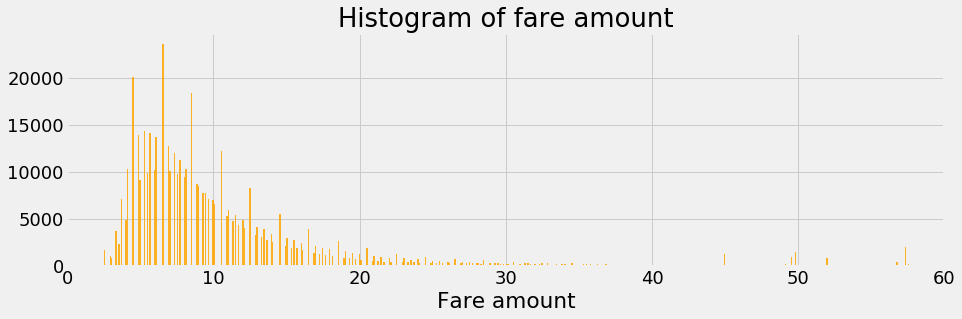

In [0]:
# Visualizing 'Fare amount' feature - 
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(df['fare_amount'], 1000, facecolor='orange', alpha=0.85)
plt.xlabel('Fare amount')
plt.title('Histogram of fare amount')
plt.xlim(0, 60)
plt.show();

The histogram of fare amount shows that most fare amount are small.

In [0]:
# checking 10 most common fare amount. These common fare are not very high which means there were short rides.
df.groupby('fare_amount').size().nlargest(10)

fare_amount
6.500     23564
4.500     20093
8.500     18332
5.300     14336
5.700     14133
4.900     13874
6.100     13765
6.900     12782
10.500    12227
7.300     12048
dtype: int64





Interesting, the most common fare amount are very small at only 6.5 and 4.5, they are very short rides.

### Passenger count

Text(0, 0.5, 'Count')

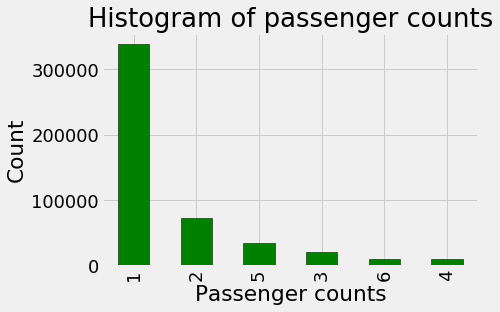

In [0]:
df['passenger_count'].value_counts().plot.bar(color = 'g', edgecolor = 'k')
plt.title('Histogram of passenger counts')
plt.xlabel('Passenger counts')
plt.ylabel('Count')

In [0]:
df.groupby('passenger_count').size()

passenger_count
1    338546
2     72482
3     21330
4     10374
5     34602
6     10382
dtype: int64

Based on the above discovery, we are going to remove taxi rides with passenger_count > 6.

In [0]:
df = df[df['passenger_count'] <= 6]

In [0]:
df.groupby('passenger_count').size()

passenger_count
1    338546
2     72482
3     21330
4     10374
5     34602
6     10382
dtype: int64

### Longitudes and Latitudes


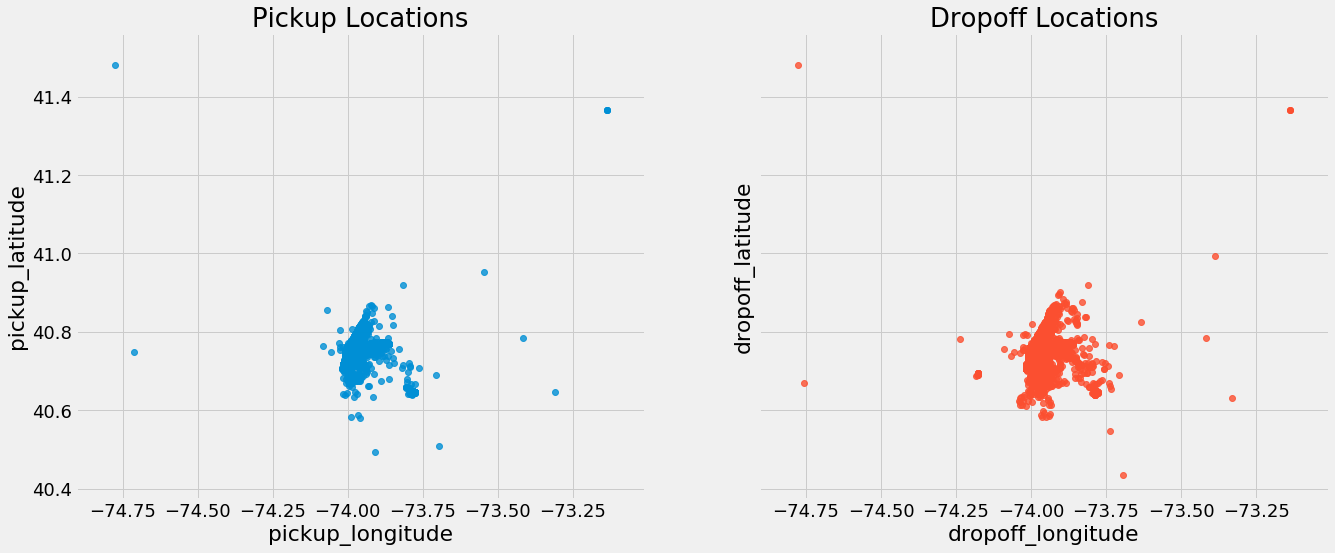

In [0]:
RSEED = 100
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = df.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = df.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

In [0]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,487716.000,487716.000,487716.000,487716.000,487716.000,487716.000
mean,11.299,-73.975,40.751,-73.974,40.751,1.690
std,9.375,0.044,0.034,0.042,0.037,1.306
min,2.500,-77.902,37.420,-77.817,37.347,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.767,-73.965,40.768,2.000
max,100.000,-70.141,43.183,-70.050,44.600,6.000


To be quick, let's create a baseline model, without Machine learning, just a simple rate calculation

In [0]:
pre_features = df.drop(["fare_amount", 'pickup_datetime', 'fare-bin'], axis = 1)
target = df["fare_amount"]

In [0]:
pre_features.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.844,40.721,-73.842,40.712,1
1,-74.016,40.711,-73.979,40.782,1
2,-73.983,40.761,-73.991,40.751,2
3,-73.987,40.733,-73.992,40.758,1
4,-73.968,40.768,-73.957,40.784,1


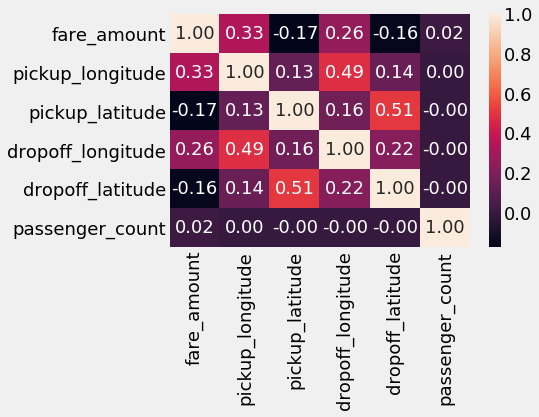

In [0]:
corr = df.corr()
heatmap = sns.heatmap(corr, annot = True, fmt ='.2f')

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(pre_features, target, random_state=0)
x_test = np.array(x_test)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)
print("Wihout any Feature Engineering")
print("Score : ",score)
rmse = sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error : ", rmse)

Wihout any Feature Engineering
Score :  0.19806282448637721
Root Mean Squared Error :  8.404437107332562


This baseline model gets us RMSE at $8.40. We expect ML achieve better than this. 

# Feature engineering

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the pickup and dropoff. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides. As the cost of a taxi ride is proportional to duration or distance, we would expect the relative distances to be a useful measure for estimating the fare.

In [0]:
# Absolute difference in latitude and longitude
df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
df['abs_lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()

1). Extract information from datetime (day of week, month, hour, day). Taxi fares change day/night or on weekdays/holidays.

2). The distance from pickup to dropoff. The longer the trip, the higher the price.

3). Add columns indicating distance from pickup or dropoff coordinates to JFK. Trips from/to JFK have a flat fare at $52. JKF : John F. Kennedy International Airport

Getting distance between two points based on latitude and longitude using haversine formula. 
https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

In [0]:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['day'] = df.pickup_datetime.dt.day
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

In [0]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,year,month,day,weekday,hour
0,4.500,2009-06-15 17:26:21+00:00,-73.844,40.721,-73.842,40.712,1,"(0.0, 5.0]",0.009,0.003,2009,6,15,0,17
1,16.900,2010-01-05 16:52:16+00:00,-74.016,40.711,-73.979,40.782,1,"(15.0, 20.0]",0.071,0.037,2010,1,5,1,16
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,"(5.0, 10.0]",0.011,0.009,2011,8,18,3,0
3,7.700,2012-04-21 04:30:42+00:00,-73.987,40.733,-73.992,40.758,1,"(5.0, 10.0]",0.025,0.004,2012,4,21,5,4
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,"(5.0, 10.0]",0.016,0.011,2010,3,9,1,7


##Manhattan and Euclidean Distance
The Minkowski Distance between two points is expressed as:

$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$
if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. You may also see these referred to as the l1 or l2 norm where the number indicates p in the equation.

**Manhattan and Euclidean Distance - only for relative distance**

**Haversine Distance - for actual distance in Km**

In [0]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)
  
df['manhattan_distance'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 1)

df['euclidean_distance'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 2)

##Haversine Distance -

In [0]:
from math import radians, cos, sin, asin, sqrt
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # 6371 is Radius of earth in kilometers. Use 3956 for miles
    return km

df['hv_distance'] = haversine_np(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'] , df['dropoff_longitude'])

In [0]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,year,month,day,weekday,hour,manhattan_distance,euclidean_distance,hv_distance
0,4.500,2009-06-15 17:26:21+00:00,-73.844,40.721,-73.842,40.712,1,"(0.0, 5.0]",0.009,0.003,2009,6,15,0,17,0.012,0.009,0.410
1,16.900,2010-01-05 16:52:16+00:00,-74.016,40.711,-73.979,40.782,1,"(15.0, 20.0]",0.071,0.037,2010,1,5,1,16,0.107,0.080,4.629
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,"(5.0, 10.0]",0.011,0.009,2011,8,18,3,0,0.019,0.014,1.001
3,7.700,2012-04-21 04:30:42+00:00,-73.987,40.733,-73.992,40.758,1,"(5.0, 10.0]",0.025,0.004,2012,4,21,5,4,0.029,0.025,0.910
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,"(5.0, 10.0]",0.016,0.011,2010,3,9,1,7,0.027,0.019,1.361


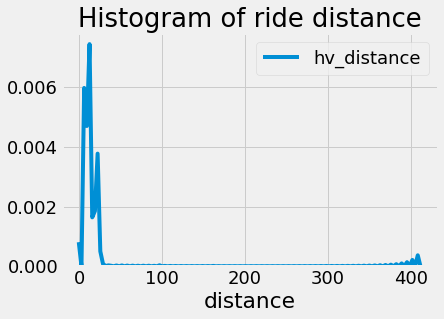

In [0]:
sns.kdeplot(df['hv_distance'])
plt.xlabel('distance')
plt.title('Histogram of ride distance')
plt.show();

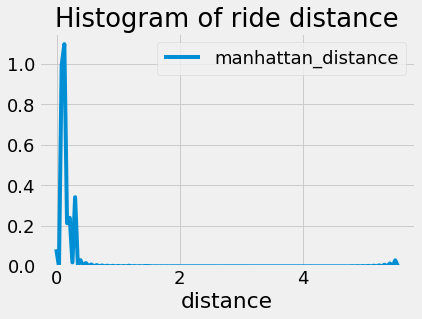

In [0]:
sns.kdeplot(df['manhattan_distance'])
plt.xlabel('distance')
plt.title('Histogram of ride distance')
plt.show();

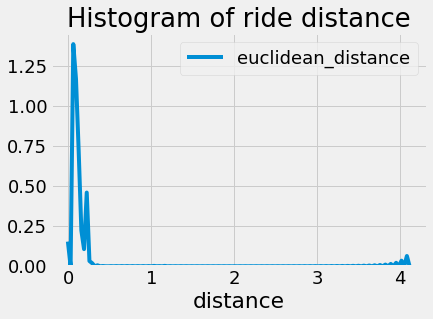

In [0]:
sns.kdeplot(df['euclidean_distance'])
plt.xlabel('distance')
plt.title('Histogram of ride distance')
plt.show();

In [0]:
df['hv_distance'].describe()

count   487716.000
mean         2.721
std          4.143
min          0.000
25%          0.854
50%          1.557
75%          2.837
max        410.896
Name: hv_distance, dtype: float64

The minimum distance is 0, we will remove all 0 distance.

In [0]:
df = df.loc[df['hv_distance'] > 0]

### Distance to/from JKF Airport

Official NYC yellow taxis have a flat rate fee from JFK to Manhattan for 52 (plus tolls and tip), Add columns indicating distance from pickup or dropoff coordinates to JFK.  There is a set fare from JFK to any destination in Manhattan, which is $52.

In [0]:
JFK_coord = (40.6413, -73.7781)

pickup_JFK = haversine_np(df['pickup_latitude'], df['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
dropoff_JFK = haversine_np(JFK_coord[0], JFK_coord[1], df['dropoff_latitude'], df['dropoff_longitude'])

In [0]:
df['distance_JKF'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
df['distance_JKF'].describe()

count   482493.000
mean        20.992
std          4.634
min          0.077
25%         20.271
50%         22.058
75%         23.147
max        449.181
Name: distance_JKF, dtype: float64

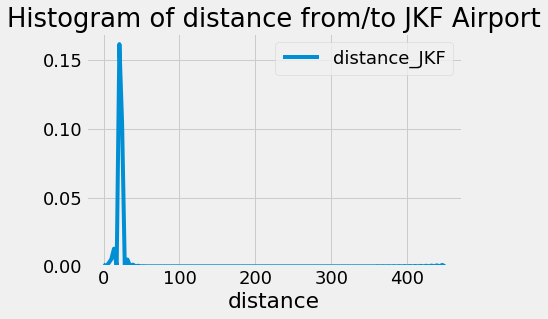

In [0]:
sns.kdeplot(df['distance_JKF'])
plt.xlabel('distance')
plt.title('Histogram of distance from/to JKF Airport')
plt.show();

In [0]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,year,month,day,weekday,hour,manhattan_distance,euclidean_distance,hv_distance,distance_JKF
0,4.500,2009-06-15 17:26:21+00:00,-73.844,40.721,-73.842,40.712,1,"(0.0, 5.0]",0.009,0.003,2009,6,15,0,17,0.012,0.009,0.410,7.397
1,16.900,2010-01-05 16:52:16+00:00,-74.016,40.711,-73.979,40.782,1,"(15.0, 20.0]",0.071,0.037,2010,1,5,1,16,0.107,0.080,4.629,22.787
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,"(5.0, 10.0]",0.011,0.009,2011,8,18,3,0,0.019,0.014,1.001,23.054
3,7.700,2012-04-21 04:30:42+00:00,-73.987,40.733,-73.992,40.758,1,"(5.0, 10.0]",0.025,0.004,2012,4,21,5,4,0.029,0.025,0.910,23.415
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,"(5.0, 10.0]",0.016,0.011,2010,3,9,1,7,0.027,0.019,1.361,20.336


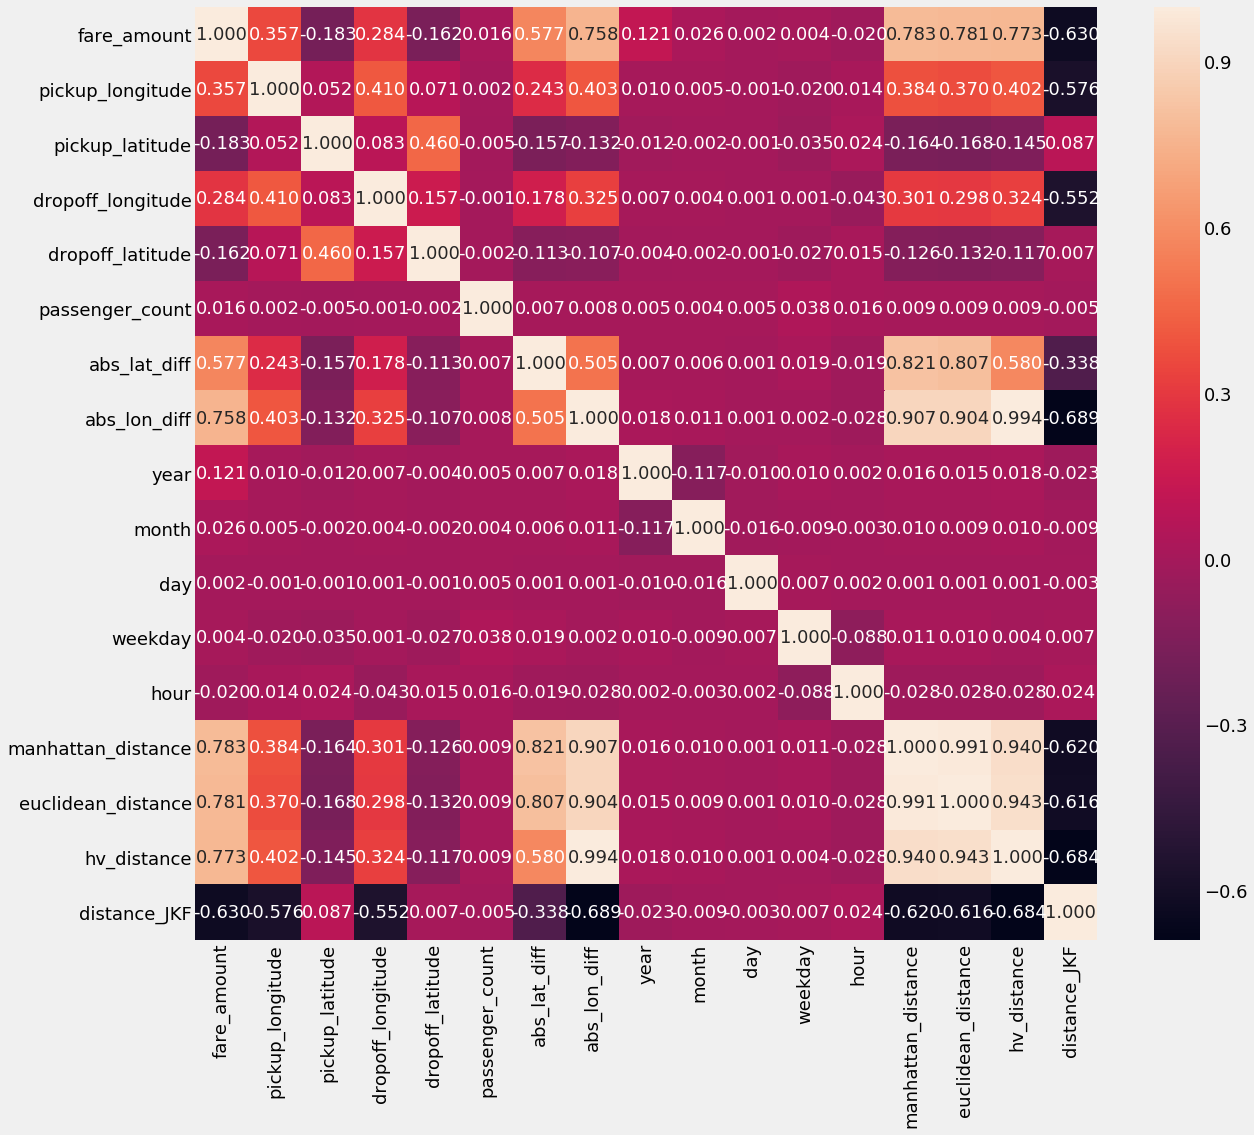

In [0]:
plt.figure(figsize = (18,16))
corr_final = df.corr()
heatmap_final = sns.heatmap(corr_final, annot = True, fmt = '.3f')

##Linear Regression


In [0]:
from sklearn.model_selection import train_test_split
final_target = df['fare_amount']
final_features = df.drop(columns=['fare_amount', 'day', 'weekday', 'hour', 'month', 'pickup_datetime', 'fare-bin'])
X_train, X_test, Y_train, Y_test = train_test_split(final_features, final_target, random_state=0)
final_features.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,year,manhattan_distance,euclidean_distance,hv_distance,distance_JKF
0,-73.844,40.721,-73.842,40.712,1,0.009,0.003,2009,0.012,0.009,0.410,7.397
1,-74.016,40.711,-73.979,40.782,1,0.071,0.037,2010,0.107,0.080,4.629,22.787
2,-73.983,40.761,-73.991,40.751,2,0.011,0.009,2011,0.019,0.014,1.001,23.054
3,-73.987,40.733,-73.992,40.758,1,0.025,0.004,2012,0.029,0.025,0.910,23.415
4,-73.968,40.768,-73.957,40.784,1,0.016,0.011,2010,0.027,0.019,1.361,20.336


In [0]:
model.fit(X_train, Y_train)
final_pred = model.predict(X_test)
print("Linear Regression Score : %.3f" % model.score(X_test, Y_test))
print("Linear Regression RMSE : %.3f" % mean_squared_error(Y_test, final_pred) ** 0.5)

Linear Regression Score : 0.701
Linear Regression RMSE : 5.084


## Random Forest Regression

###Hyper-parameter Tuning of Random Forrest Regressor using GridSearchCV

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
rf.fit(X_train, Y_train)
final_pred = rf.predict(X_test)
print("Random Forest Regression Score : ",rf.score(X_test, Y_test))
print("Random Forest Regression RMSE: %.3f" % mean_squared_error(Y_test, final_pred) ** 0.5)

Random Forest Regression Score :  0.8327912003080375
Random Forest Regression RMSE: 3.802


In [0]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()
param_grid = { 
        "n_estimators"      : [100,200],
        "min_samples_split" : [2,4,6],
        "bootstrap": [True, False],
        "max_depth" : [2,4,6,8]
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
grid.fit(X_train, Y_train)
print(grid.best_score_ , grid.best_params_)

# After running the GridSearchCV we got - 

KeyboardInterrupt: ignored

### LightGBM

In [0]:
import lightgbm as lgb

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [0]:
train_set = lgb.Dataset(X_train, Y_train, silent=True)

In [0]:
lb = lgb.train(params, train_set = train_set, num_boost_round=300)

In [0]:
y_pred = lb.predict(X_test, num_iteration = lb.best_iteration)

In [0]:
print("Light GBM RMSE: %.3f" % mean_squared_error(Y_test, y_pred) ** 0.5)

In [0]:
import pickle
from sklearn.externals import joblib
filename = 'fare_prediction.pkl'
joblib.dump(model, filename)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['fare_prediction.pkl']

In [0]:
mdl = joblib.load('fare_prediction.pkl')
y = mdl.predict([[-74.016048,
40.711303,
-73.979268,
40.782004,	1,	0.071,	0.037,	2010,	0.107,	0.080,	4.629,	22.787]])
y[0]

17.75161786294484

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('fare_prediction.pkl')
file.Upload()

In [0]:
from google.colab import files
files.download('fare_prediction.pkl')

In [0]:
md = joblib.load('fare_prediction.pkl')
md.predict(X_test)
md.score(X_test, Y_test)
print(X_test)

In [0]:
lst = "20,20"
a = lst.split(",")
b = int(a[0])

AttributeError: ignored

In [0]:
print(final_features['pickup_longitude'][1])
print(final_features['pickup_latitude'][1])
print(final_features['dropoff_longitude'][1])
print(final_features['dropoff_latitude'][1])


-74.016048
40.711303
-73.979268
40.782004
